In [1]:
# Enable autoreload to auto-reload modules when edited
%reload_ext autoreload
%autoreload 2

# Standard libraries
import sys
import time
import calendar
import warnings
from datetime import datetime, timedelta, date
from pathlib import Path
import logging

# Data science and ML
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Machine learning
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from xgboost import XGBClassifier
import shap

# BigQuery
import pandas_gbq
from google.cloud import bigquery

# Serialization
import cloudpickle as pkl

# Custom modules
import dataimp.data_preps
from dataimp import *

# Pandas display options for large DataFrames
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

# Initialize BigQuery client once
client = bigquery.Client()

In [2]:
target = 'mf_31-05'
model_name = f'{target}.pkl'

In [3]:
import os
print(os.path.exists(f'{target}/{model_name}'))

True


In [4]:
print(os.path.getsize(f'{target}/{model_name}'))

414077


In [5]:
with open(f'{target}/{model_name}', 'rb') as f:
    model = pkl.load(f)
    
print(os.path.getsize(f'{target}/{model_name}'))

414077


In [6]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9105420212078328, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=4.593883904822779, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025089394316793384,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=350, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

## Import Model and Create OOT Validation data

In [7]:
import pandas as pd
import numpy as np

# Initialize empty DataFrame
data = pd.DataFrame()

# Snapshot date list
date_ranges = ['digigold_feature_2025-02-01', 'digigold_feature_2025-03-01']

# Load all PIFA-sourced DigiGold users with YEAR_MONTH
pifa_query = """
    SELECT DISTINCT
        CAST(New_Mobile_Number AS INT64) AS mobilenumber,
        FORMAT_DATE('%Y-%m', PARSE_DATE('%B %Y', MONTH_YEAR)) AS YEAR_MONTH
    FROM
        `abcd-dataplatform.abcd_data_model.FY_Xsell_final_fct2`
    WHERE
        product_desc = 'App_Business'
        AND pifa_flag = 1 
        AND new_lob = 'MF'
"""
pifa_digigold = client.query(pifa_query).to_dataframe()

# Loop through each snapshot date
for date in date_ranges:
    file_path = f'snapshots/{date}.csv'
    model_base = pd.read_csv(file_path)
    print(f"Loaded {file_path}, shape: {model_base.shape}")

    # Extract 'YYYY-MM' from snapshot
    year_month = date.split('_')[-1][:7]

    # Get DigiGold investors for that month
    target_base_query = f"""
        SELECT DISTINCT
            CAST(mobilenumber AS INT64) AS mobilenumber,
            month_year,
            type_of_investment,
            total_investment
        FROM 
            `abcd-dataplatform.abcd_data_science_app.INVESTMENT_MONTH_ON_MONTH_DATA`
        WHERE
            LOWER(type_of_investment) IN ('mutual_fund','mutual fund') 
            AND month_year = '{year_month}'
        QUALIFY ROW_NUMBER() OVER (PARTITION BY mobilenumber ORDER BY total_investment DESC) = 1
    """
    target_base = client.query(target_base_query).to_dataframe()

    # Add YEAR_MONTH column to target base for join
    target_base['YEAR_MONTH'] = year_month

    # Remove PIFA DigiGold users
    target_base = target_base.merge(
        pifa_digigold,
        how='left',
        on=['mobilenumber', 'YEAR_MONTH'],
        indicator=True
    )
    target_base = target_base[target_base['_merge'] == 'left_only'].drop(columns=['_merge'])

    # Assign final gold target
    model_base['target_mf'] = np.where(
        model_base['mobilenumber'].isin(target_base['mobilenumber']),
        1,
        0
    )

    # Add snapshot date column
    clean_date = date.split('_')[-1]
    model_base['date'] = clean_date
    
    # Print base and target stats
    base_count = model_base.shape[0]
    target_count = model_base['target_mf'].sum()
    response_rate = round((target_count / base_count) * 100, 2) if base_count > 0 else 0
    print(f"Snapshot Month: {year_month}")
    print(f"Base Count: {base_count}")
    print(f"Target Count: {target_count}")
    print(f"Response Rate: {response_rate}%")
    print('*'*50)

    # Append this snapshot to the full data
    data = pd.concat([data, model_base], ignore_index=True)

# Final data shape
print(f"Final combined data shape: {data.shape}")

Loaded snapshots/digigold_feature_2025-02-01.csv, shape: (4206026, 173)
Snapshot Month: 2025-02
Base Count: 4206026
Target Count: 341
Response Rate: 0.01%
**************************************************
Loaded snapshots/digigold_feature_2025-03-01.csv, shape: (4472174, 173)
Snapshot Month: 2025-03
Base Count: 4472174
Target Count: 355
Response Rate: 0.01%
**************************************************
Final combined data shape: (8678200, 175)


In [8]:
data.columns.to_list()

['mobilenumber',
 'customer_id',
 'target_gold',
 'fixed_deposit_1m',
 'fixed_deposit_3m',
 'fixed_deposit_6m',
 'fixed_deposit_12m',
 'recurring_deposit_1m',
 'recurring_deposit_3m',
 'recurring_deposit_6m',
 'recurring_deposit_12m',
 'term_deposit_1m',
 'term_deposit_3m',
 'term_deposit_6m',
 'term_deposit_12m',
 'provident_fund_1m',
 'provident_fund_3m',
 'provident_fund_6m',
 'provident_fund_12m',
 'nps_1m',
 'nps_3m',
 'nps_6m',
 'nps_12m',
 'mutual_fund_1m',
 'mutual_fund_3m',
 'mutual_fund_6m',
 'mutual_fund_12m',
 'trading_1m',
 'trading_3m',
 'trading_6m',
 'trading_12m',
 'fixed_deposit_1m_3m_ratio',
 'fixed_deposit_3m_6m_ratio',
 'fixed_deposit_6m_12m_ratio',
 'fixed_deposit_3m_12m_ratio',
 'recurring_deposit_1m_3m_ratio',
 'recurring_deposit_3m_6m_ratio',
 'recurring_deposit_6m_12m_ratio',
 'recurring_deposit_3m_12m_ratio',
 'term_deposit_1m_3m_ratio',
 'term_deposit_3m_6m_ratio',
 'term_deposit_6m_12m_ratio',
 'term_deposit_3m_12m_ratio',
 'provident_fund_1m_3m_ratio',
 'p

In [9]:
data.date.value_counts()

date
2025-03-01    4472174
2025-02-01    4206026
Name: count, dtype: int64

In [10]:
data.drop(columns=['target_gold'],inplace=True)

# repeat customer Analysis

# check the code for OOT from below Onward

In [11]:
#data.drop(columns=['target_gold'],inplace=True)

In [12]:
data.head()

,mobilenumber,customer_id,fixed_deposit_1m,fixed_deposit_3m,fixed_deposit_6m,fixed_deposit_12m,recurring_deposit_1m,recurring_deposit_3m,recurring_deposit_6m,recurring_deposit_12m,term_deposit_1m,term_deposit_3m,term_deposit_6m,term_deposit_12m,provident_fund_1m,provident_fund_3m,provident_fund_6m,provident_fund_12m,nps_1m,nps_3m,nps_6m,nps_12m,mutual_fund_1m,mutual_fund_3m,mutual_fund_6m,mutual_fund_12m,trading_1m,trading_3m,trading_6m,trading_12m,fixed_deposit_1m_3m_ratio,fixed_deposit_3m_6m_ratio,fixed_deposit_6m_12m_ratio,fixed_deposit_3m_12m_ratio,recurring_deposit_1m_3m_ratio,recurring_deposit_3m_6m_ratio,recurring_deposit_6m_12m_ratio,recurring_deposit_3m_12m_ratio,term_deposit_1m_3m_ratio,term_deposit_3m_6m_ratio,term_deposit_6m_12m_ratio,term_deposit_3m_12m_ratio,provident_fund_1m_3m_ratio,provident_fund_3m_6m_ratio,provident_fund_6m_12m_ratio,provident_fund_3m_12m_ratio,nps_1m_3m_ratio,nps_3m_6m_ratio,nps_6m_12m_ratio,nps_3m_12m_ratio,mutual_fund_1m_3m_ratio,mutual_fund_3m_6m_ratio,mutual_fund_6m_12m_ratio,mutual_fund_3m_12m_ratio,trading_1m_3m_ratio,trading_3m_6m_ratio,trading_6m_12m_ratio,trading_3m_12m_ratio,fixed_deposit_1m_scaled,recurring_deposit_1m_scaled,term_deposit_1m_scaled,provident_fund_1m_scaled,nps_1m_scaled,mutual_fund_1m_scaled,trading_1m_scaled,fixed_deposit_3m_scaled,recurring_deposit_3m_scaled,term_deposit_3m_scaled,provident_fund_3m_scaled,nps_3m_scaled,mutual_fund_3m_scaled,trading_3m_scaled,fixed_deposit_6m_scaled,recurring_deposit_6m_scaled,term_deposit_6m_scaled,provident_fund_6m_scaled,nps_6m_scaled,mutual_fund_6m_scaled,trading_6m_scaled,fixed_deposit_12m_scaled,recurring_deposit_12m_scaled,term_deposit_12m_scaled,provident_fund_12m_scaled,nps_12m_scaled,mutual_fund_12m_scaled,trading_12m_scaled,salary_1m,salary_3m,salary_6m,salary_12m,amt_insurance_spend_1m,amt_investment_spend_1m,amt_medical_spend_1m,amt_bills_utilities_spend_1m,amt_shopping_purchase_spend_1m,amt_online_shopping_spend_1m,amt_entertainment_spend_1m,amt_groceries_spend_1m,amt_education_spend_1m,amt_travel_spend_1m,amt_emi_repayment_spend_1m,amt_housing_services_spend_1m,amt_vehicle_expenses_spend_1m,amt_insurance_spend_3m,amt_investment_spend_3m,amt_medical_spend_3m,amt_bills_utilities_spend_3m,amt_shopping_purchase_spend_3m,amt_online_shopping_spend_3m,amt_entertainment_spend_3m,amt_groceries_spend_3m,amt_education_spend_3m,amt_travel_spend_3m,amt_emi_repayment_spend_3m,amt_housing_services_spend_3m,amt_vehicle_expenses_spend_3m,amt_insurance_spend_6m,amt_investment_spend_6m,amt_medical_spend_6m,amt_bills_utilities_spend_6m,amt_shopping_purchase_spend_6m,amt_online_shopping_spend_6m,amt_entertainment_spend_6m,amt_groceries_spend_6m,amt_education_spend_6m,amt_travel_spend_6m,amt_emi_repayment_spend_6m,amt_housing_services_spend_6m,amt_vehicle_expenses_spend_6m,amt_insurance_spend_12m,amt_investment_spend_12m,amt_medical_spend_12m,amt_bills_utilities_spend_12m,amt_shopping_purchase_spend_12m,amt_online_shopping_spend_12m,amt_entertainment_spend_12m,amt_groceries_spend_12m,amt_education_spend_12m,amt_travel_spend_12m,amt_emi_repayment_spend_12m,amt_housing_services_spend_12m,amt_vehicle_expenses_spend_12m,IsGymLover,IsSingle,IsParent,insuranceservices,occupation,bureau_income,gender,age_in_years,pl_enq_count_3m,pl_enq_amt_3m,pl_enq_count_6m,pl_enq_amt_6m,hfl_enq_count_3m,hfl_enq_amt_3m,hfl_enq_count_6m,hfl_enq_amt_6m,bl_enq_count_3m,bl_enq_amt_3m,bl_enq_count_6m,bl_enq_amt_6m,cc_enq_count_3m,cc_enq_amt_3m,cc_enq_count_6m,cc_enq_amt_6m,pl_loan_closed_12m,hfl_loan_closed_12m,business_loan_closed_12m,pl_loan_open_count_12m,Tier,EXPERIAN_Score_V3,target_mf,date
0,8106058587,1628486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.

# encoding columns

In [13]:
num_cols = data.select_dtypes(include='number').columns
cat_cols = data.select_dtypes(include='object').columns

In [14]:
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder
#One-hot encode the categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(data[cat_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols), index=data.index)

In [15]:
#Combine numeric and encoded categorical features
data = pd.concat([data, encoded_df], axis=1)
data.head()

,mobilenumber,customer_id,fixed_deposit_1m,fixed_deposit_3m,fixed_deposit_6m,fixed_deposit_12m,recurring_deposit_1m,recurring_deposit_3m,recurring_deposit_6m,recurring_deposit_12m,term_deposit_1m,term_deposit_3m,term_deposit_6m,term_deposit_12m,provident_fund_1m,provident_fund_3m,provident_fund_6m,provident_fund_12m,nps_1m,nps_3m,nps_6m,nps_12m,mutual_fund_1m,mutual_fund_3m,mutual_fund_6m,mutual_fund_12m,trading_1m,trading_3m,trading_6m,trading_12m,fixed_deposit_1m_3m_ratio,fixed_deposit_3m_6m_ratio,fixed_deposit_6m_12m_ratio,fixed_deposit_3m_12m_ratio,recurring_deposit_1m_3m_ratio,recurring_deposit_3m_6m_ratio,recurring_deposit_6m_12m_ratio,recurring_deposit_3m_12m_ratio,term_deposit_1m_3m_ratio,term_deposit_3m_6m_ratio,term_deposit_6m_12m_ratio,term_deposit_3m_12m_ratio,provident_fund_1m_3m_ratio,provident_fund_3m_6m_ratio,provident_fund_6m_12m_ratio,provident_fund_3m_12m_ratio,nps_1m_3m_ratio,nps_3m_6m_ratio,nps_6m_12m_ratio,nps_3m_12m_ratio,mutual_fund_1m_3m_ratio,mutual_fund_3m_6m_ratio,mutual_fund_6m_12m_ratio,mutual_fund_3m_12m_ratio,trading_1m_3m_ratio,trading_3m_6m_ratio,trading_6m_12m_ratio,trading_3m_12m_ratio,fixed_deposit_1m_scaled,recurring_deposit_1m_scaled,term_deposit_1m_scaled,provident_fund_1m_scaled,nps_1m_scaled,mutual_fund_1m_scaled,trading_1m_scaled,fixed_deposit_3m_scaled,recurring_deposit_3m_scaled,term_deposit_3m_scaled,provident_fund_3m_scaled,nps_3m_scaled,mutual_fund_3m_scaled,trading_3m_scaled,fixed_deposit_6m_scaled,recurring_deposit_6m_scaled,term_deposit_6m_scaled,provident_fund_6m_scaled,nps_6m_scaled,mutual_fund_6m_scaled,trading_6m_scaled,fixed_deposit_12m_scaled,recurring_deposit_12m_scaled,term_deposit_12m_scaled,provident_fund_12m_scaled,nps_12m_scaled,mutual_fund_12m_scaled,trading_12m_scaled,salary_1m,salary_3m,salary_6m,salary_12m,amt_insurance_spend_1m,amt_investment_spend_1m,amt_medical_spend_1m,amt_bills_utilities_spend_1m,amt_shopping_purchase_spend_1m,amt_online_shopping_spend_1m,amt_entertainment_spend_1m,amt_groceries_spend_1m,amt_education_spend_1m,amt_travel_spend_1m,amt_emi_repayment_spend_1m,amt_housing_services_spend_1m,amt_vehicle_expenses_spend_1m,amt_insurance_spend_3m,amt_investment_spend_3m,amt_medical_spend_3m,amt_bills_utilities_spend_3m,amt_shopping_purchase_spend_3m,amt_online_shopping_spend_3m,amt_entertainment_spend_3m,amt_groceries_spend_3m,amt_education_spend_3m,amt_travel_spend_3m,amt_emi_repayment_spend_3m,amt_housing_services_spend_3m,amt_vehicle_expenses_spend_3m,amt_insurance_spend_6m,amt_investment_spend_6m,amt_medical_spend_6m,amt_bills_utilities_spend_6m,amt_shopping_purchase_spend_6m,amt_online_shopping_spend_6m,amt_entertainment_spend_6m,amt_groceries_spend_6m,amt_education_spend_6m,amt_travel_spend_6m,amt_emi_repayment_spend_6m,amt_housing_services_spend_6m,amt_vehicle_expenses_spend_6m,amt_insurance_spend_12m,amt_investment_spend_12m,amt_medical_spend_12m,amt_bills_utilities_spend_12m,amt_shopping_purchase_spend_12m,amt_online_shopping_spend_12m,amt_entertainment_spend_12m,amt_groceries_spend_12m,amt_education_spend_12m,amt_travel_spend_12m,amt_emi_repayment_spend_12m,amt_housing_services_spend_12m,amt_vehicle_expenses_spend_12m,IsGymLover,IsSingle,IsParent,insuranceservices,occupation,bureau_income,gender,age_in_years,pl_enq_count_3m,pl_enq_amt_3m,pl_enq_count_6m,pl_enq_amt_6m,hfl_enq_count_3m,hfl_enq_amt_3m,hfl_enq_count_6m,hfl_enq_amt_6m,bl_enq_count_3m,bl_enq_amt_3m,bl_enq_count_6m,bl_enq_amt_6m,cc_enq_count_3m,cc_enq_amt_3m,cc_enq_count_6m,cc_enq_amt_6m,pl_loan_closed_12m,hfl_loan_closed_12m,business_loan_closed_12m,pl_loan_open_count_12m,Tier,EXPERIAN_Score_V3,target_mf,date,occupation_Salaried,occupation_Self Employed,occupation_Self Employed Professional,occupation_Unknown,occupation_nan,gender_Female,gender_Male,gender_Others,gender_Unknown,gender_nan,Tier_Tier1,Tier_Tier2,Tier_Tier3,Tier_nan,date_2025-02-01,date_2025-03-01
0,8106058587,1628486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [16]:
data.drop(columns=['occupation', 'gender', 'Tier'], inplace=True)
data.columns.to_list()

['mobilenumber',
 'customer_id',
 'fixed_deposit_1m',
 'fixed_deposit_3m',
 'fixed_deposit_6m',
 'fixed_deposit_12m',
 'recurring_deposit_1m',
 'recurring_deposit_3m',
 'recurring_deposit_6m',
 'recurring_deposit_12m',
 'term_deposit_1m',
 'term_deposit_3m',
 'term_deposit_6m',
 'term_deposit_12m',
 'provident_fund_1m',
 'provident_fund_3m',
 'provident_fund_6m',
 'provident_fund_12m',
 'nps_1m',
 'nps_3m',
 'nps_6m',
 'nps_12m',
 'mutual_fund_1m',
 'mutual_fund_3m',
 'mutual_fund_6m',
 'mutual_fund_12m',
 'trading_1m',
 'trading_3m',
 'trading_6m',
 'trading_12m',
 'fixed_deposit_1m_3m_ratio',
 'fixed_deposit_3m_6m_ratio',
 'fixed_deposit_6m_12m_ratio',
 'fixed_deposit_3m_12m_ratio',
 'recurring_deposit_1m_3m_ratio',
 'recurring_deposit_3m_6m_ratio',
 'recurring_deposit_6m_12m_ratio',
 'recurring_deposit_3m_12m_ratio',
 'term_deposit_1m_3m_ratio',
 'term_deposit_3m_6m_ratio',
 'term_deposit_6m_12m_ratio',
 'term_deposit_3m_12m_ratio',
 'provident_fund_1m_3m_ratio',
 'provident_fund_3m

In [18]:
columns = pd.read_csv(f'top_features_{target}.csv')['0'].to_list()
columns

['amt_online_shopping_spend_12m',
 'amt_education_spend_3m',
 'amt_travel_spend_12m',
 'amt_investment_spend_12m',
 'occupation_Salaried',
 'amt_medical_spend_12m',
 'Tier_Tier2',
 'Tier_Tier1',
 'mutual_fund_3m',
 'amt_medical_spend_3m',
 'salary_3m',
 'amt_insurance_spend_12m',
 'amt_groceries_spend_12m',
 'amt_investment_spend_1m',
 'cc_enq_count_3m',
 'EXPERIAN_Score_V3']

In [19]:
x_test = data.copy()
y_test = data['target_mf'].copy()

In [20]:
x_test.columns.to_list()

['mobilenumber',
 'customer_id',
 'fixed_deposit_1m',
 'fixed_deposit_3m',
 'fixed_deposit_6m',
 'fixed_deposit_12m',
 'recurring_deposit_1m',
 'recurring_deposit_3m',
 'recurring_deposit_6m',
 'recurring_deposit_12m',
 'term_deposit_1m',
 'term_deposit_3m',
 'term_deposit_6m',
 'term_deposit_12m',
 'provident_fund_1m',
 'provident_fund_3m',
 'provident_fund_6m',
 'provident_fund_12m',
 'nps_1m',
 'nps_3m',
 'nps_6m',
 'nps_12m',
 'mutual_fund_1m',
 'mutual_fund_3m',
 'mutual_fund_6m',
 'mutual_fund_12m',
 'trading_1m',
 'trading_3m',
 'trading_6m',
 'trading_12m',
 'fixed_deposit_1m_3m_ratio',
 'fixed_deposit_3m_6m_ratio',
 'fixed_deposit_6m_12m_ratio',
 'fixed_deposit_3m_12m_ratio',
 'recurring_deposit_1m_3m_ratio',
 'recurring_deposit_3m_6m_ratio',
 'recurring_deposit_6m_12m_ratio',
 'recurring_deposit_3m_12m_ratio',
 'term_deposit_1m_3m_ratio',
 'term_deposit_3m_6m_ratio',
 'term_deposit_6m_12m_ratio',
 'term_deposit_3m_12m_ratio',
 'provident_fund_1m_3m_ratio',
 'provident_fund_3m

In [21]:
x_test = x_test[columns + ['date']]
x_test.shape

(8678200, 17)

In [22]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8678200 entries, 0 to 8678199
Data columns (total 17 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   amt_online_shopping_spend_12m  float64
 1   amt_education_spend_3m         float64
 2   amt_travel_spend_12m           float64
 3   amt_investment_spend_12m       float64
 4   occupation_Salaried            float64
 5   amt_medical_spend_12m          float64
 6   Tier_Tier2                     float64
 7   Tier_Tier1                     float64
 8   mutual_fund_3m                 float64
 9   amt_medical_spend_3m           float64
 10  salary_3m                      float64
 11  amt_insurance_spend_12m        float64
 12  amt_groceries_spend_12m        float64
 13  amt_investment_spend_1m        float64
 14  cc_enq_count_3m                float64
 15  EXPERIAN_Score_V3              float64
 16  date                           object 
dtypes: float64(16), object(1)
memory usage: 1.1+ G

## Evaluate Model Performance

In [23]:
for date in date_ranges:
    date = date.split('_')[-1]
    
    test_auc_scores = []
    
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    
    x_oot = x_test[x_test.date == date].reset_index(drop=True)
    y_oot = y_test[x_test.date == date].reset_index(drop=True)
    
    for train_index, test_index in sss.split(x_oot, y_oot):
        x_val, y_val = x_oot.loc[train_index, columns], y_oot.iloc[train_index]
        
        auc_score = roc_auc_score(y_val, model.predict_proba(x_val)[:, 1])
        test_auc_scores.append(auc_score)

    test_auc = np.mean(test_auc_scores)
    print(f"""
    OOT Gini for {date}:
        Fold 1: {2 * test_auc_scores[0] - 1:.2f}
        Fold 2: {2 * test_auc_scores[1] - 1:.2f}
        Fold 3: {2 * test_auc_scores[2] - 1:.2f}
        Fold 4: {2 * test_auc_scores[3] - 1:.2f}
        Fold 5: {2 * test_auc_scores[4] - 1:.2f}

    Average Gini = {2 * test_auc - 1:.2f}
    """)


    OOT Gini for 2025-02-01:
        Fold 1: 0.86
        Fold 2: 0.85
        Fold 3: 0.84
        Fold 4: 0.85
        Fold 5: 0.84

    Average Gini = 0.85
    

    OOT Gini for 2025-03-01:
        Fold 1: 0.87
        Fold 2: 0.86
        Fold 3: 0.88
        Fold 4: 0.87
        Fold 5: 0.87

    Average Gini = 0.87
    


In [24]:
from IPython.display import display, HTML, Image

In [25]:
for date in date_ranges:
    date = date.split('_')[-1]
    
    x_oot = x_test[x_test.date == date][columns].reset_index(drop=True)
    y_oot = y_test[x_test.date == date].reset_index(drop=True)

    # Predict probabilities
    y_pred_proba = model.predict_proba(x_oot)[:, 1]
    
    # Create Series with correct index
    y_pred_proba_series = pd.Series(y_pred_proba, index=y_oot.index)
    
    # Decile binning using ranks
    deciles = pd.qcut(y_pred_proba_series.rank(method='first'), q=10, labels=False) + 1

    # Combine into DataFrame
    deciles_df = pd.DataFrame({
        'Probability': y_pred_proba_series,
        'Actual': y_oot,
        'Decile': deciles,
        'Bin Size': 1
    }).sort_values(['Decile', 'Probability'], ascending=False)

    # Aggregate decile metrics
    agg_deciles_df = deciles_df.groupby('Decile').agg({
        'Probability': ['mean'], #, 'nunique'
        'Actual': 'sum',
        'Bin Size': 'sum'
    }).reset_index().sort_values(['Decile'], ascending=False)

    # Clean columns
    agg_deciles_df['Actual'] = agg_deciles_df.pop(('Actual', 'sum'))
    agg_deciles_df.columns = ['Decile', 'Probability_mean', 'Bin Size', 'Actual'] #Probability_nunique

    # Add metrics
    agg_deciles_df['response_rate'] = 100*agg_deciles_df['Actual'] / y_oot.shape[0]
    agg_deciles_df['decile_recall'] = agg_deciles_df['Actual'] / y_oot.sum()
    agg_deciles_df['capture_rate'] = agg_deciles_df['Actual'].cumsum() * 100 / y_oot.sum()

    # Display
    display(HTML(f"<h3>Decile Analysis for {date}</h3>{agg_deciles_df.to_html(index=False)}"))

Decile,Probability_mean,Bin Size,Actual,response_rate,decile_recall,capture_rate
10,0.67,420603,276,0.01,0.81,80.94
9,0.37,420602,24,0.00,0.07,87.98
8,0.29,420603,13,0.00,0.04,91.79
7,0.26,420602,13,0.00,0.04,95.60
6,0.18,420603,4,0.00,0.01,96.77
5,0.11,420602,2,0.00,0.01,97.36
4,0.08,420603,0,0.00,0.00,97.36
3,0.07,420602,3,0.00,0.01,98.24
2,0.06,420603,3,0.00,0.01,99.12
1,0.04,420603,3,0.00,0.01,100.00


Decile,Probability_mean,Bin Size,Actual,response_rate,decile_recall,capture_rate
10,0.66,447218,294,0.01,0.83,82.82
9,0.36,447217,25,0.00,0.07,89.86
8,0.29,447217,12,0.00,0.03,93.24
7,0.26,447218,11,0.00,0.03,96.34
6,0.18,447217,3,0.00,0.01,97.18
5,0.11,447217,2,0.00,0.01,97.75
4,0.08,447218,3,0.00,0.01,98.59
3,0.07,447217,3,0.00,0.01,99.44
2,0.06,447217,1,0.00,0.00,99.72
1,0.04,447218,1,0.00,0.00,100.00


# more visual added in gains chart

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

for date_str in date_ranges:
    date = date_str.split('_')[-1]  # Extract actual date
    oot_period_label = f"{date}_oot_period"  # Label for file naming

    x_oot = x_test[x_test.date == date][columns].reset_index(drop=True)
    y_oot = y_test[x_test.date == date].reset_index(drop=True)

    y_pred_proba = model.predict_proba(x_oot)[:, 1]
    
    val_combined = pd.DataFrame({
        'combined_disbursed_target': y_oot,
        'pred_prob1': y_pred_proba
    })

    val_combined["rank"] = val_combined["pred_prob1"].rank(method="first")
    val_combined["Decile"] = pd.qcut(val_combined["rank"], 10, labels=False) + 1

    gain = val_combined.groupby('Decile').agg(
        num_responses=('combined_disbursed_target', 'sum'),
        total=('combined_disbursed_target', 'count'),
        min_prob=('pred_prob1', 'min'),
        max_prob=('pred_prob1', 'max')
    ).reset_index()

    gain.sort_values(by="Decile", ascending=False, inplace=True)

    gain['response_rate'] = gain['num_responses'] / gain['total']
    gain['cumulative_response'] = gain['num_responses'].cumsum()
    gain['cumulative_response_rate'] = gain['cumulative_response'] / gain['num_responses'].sum()
    gain['lift'] = gain['cumulative_response_rate'] / (gain['total'].cumsum() / gain['total'].sum())
    gain['Decile Range'] = gain.apply(lambda row: f"[{row['min_prob']:.4f}, {row['max_prob']:.4f}]", axis=1)

    gain = gain[["Decile", "Decile Range", "num_responses", "total", 
                 "response_rate", "cumulative_response", "cumulative_response_rate", "lift"]]

    print(f"\n=== Gains Table for {date} ===")
    print(gain)

    # Save decile table to CSV
    gain.to_csv(f"{target}_{oot_period_label}_decile_gains.csv", index=False)

    # Gains Chart
    plt.figure(figsize=(10, 5))
    plt.plot(gain['total'].cumsum() / gain['total'].sum(), gain['cumulative_response_rate'], label="Model Gains", color='blue')
    plt.plot(gain['total'].cumsum() / gain['total'].sum(), gain['total'].cumsum() / gain['total'].sum(), label="Random (Baseline)", linestyle="dashed", color='gray')
    plt.xlabel("Cumulative % of Population")
    plt.ylabel("Cumulative Response Rate")
    plt.title(f"Gains Chart for {date}")
    plt.legend()
    plt.grid()
    plt.savefig(f"{target}_{oot_period_label}_gains.png", bbox_inches='tight')
    plt.close()

    # Lift Chart
    plt.figure(figsize=(10, 5))
    plt.plot(gain['total'].cumsum() / gain['total'].sum(), gain['lift'], label="Model Lift", color='green')
    plt.xlabel("Cumulative % of Population")
    plt.ylabel("Lift")
    plt.title(f"Lift Chart for {date}")
    plt.legend()
    plt.grid()
    plt.savefig(f"{target}_{oot_period_label}_lift.png", bbox_inches='tight')
    plt.close()

    # Response Rate Chart
    plt.figure(figsize=(10, 5))
    plt.plot(gain['Decile'], gain['response_rate'], label="Response Rate per Decile", marker='o', color='purple')
    plt.plot(gain['Decile'], gain['cumulative_response_rate'], label="Cumulative Response Rate", marker='s', linestyle="dashed", color='red')
    plt.xlabel("Decile")
    plt.ylabel("Response Rate")
    plt.title(f"Response Rate by Decile for {date}")
    plt.legend()
    plt.grid()
    plt.savefig(f"{target}_{oot_period_label}_response_rate.png", bbox_inches='tight')
    plt.close()


=== Gains Table for 2025-02-01 ===
   Decile      Decile Range  num_responses   total  response_rate  \
9      10  [0.4486, 0.9933]            276  420603           0.00   
8       9  [0.2975, 0.4486]             24  420602           0.00   
7       8  [0.2878, 0.2975]             13  420603           0.00   
6       7  [0.2225, 0.2878]             13  420602           0.00   
5       6  [0.1399, 0.2225]              4  420603           0.00   
4       5  [0.0914, 0.1399]              2  420602           0.00   
3       4  [0.0707, 0.0914]              0  420603           0.00   
2       3  [0.0670, 0.0707]              3  420602           0.00   
1       2  [0.0538, 0.0670]              3  420603           0.00   
0       1  [0.0131, 0.0538]              3  420603           0.00   

   cumulative_response  cumulative_response_rate  lift  
9                  276                      0.81  8.09  
8                  300                      0.88  4.40  
7                  313           

In [27]:
y_pred_proba

array([0.64111334, 0.3699782 , 0.3913241 , ..., 0.42009878, 0.1580982 ,
       0.14438419], dtype=float32)

<Axes: >

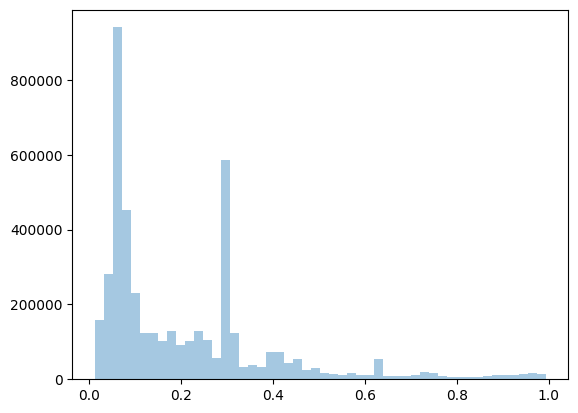

In [28]:
sns.distplot(x=y_pred_proba,kde=False)

In [29]:
average_event_rate = y_test.sum() / y_test.shape[0]
f"{average_event_rate * 100 :.2f}%"

'0.01%'

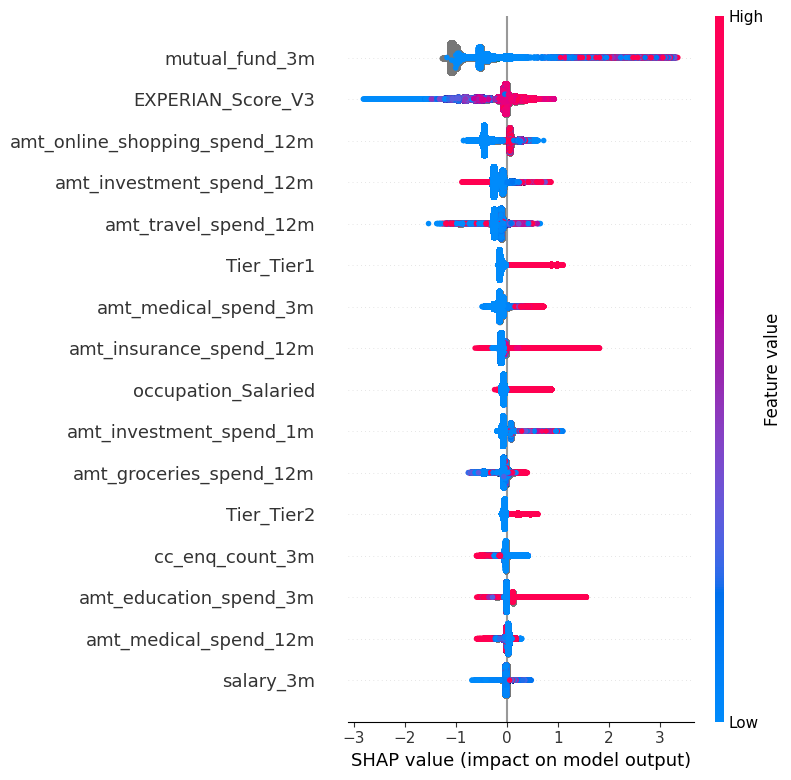

In [30]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test[columns])
shap.summary_plot(shap_values, x_test[columns])

In [31]:
x_test.isnull().sum(axis=0) / x_test.shape[0]

amt_online_shopping_spend_12m   0.26
amt_education_spend_3m          0.26
amt_travel_spend_12m            0.26
amt_investment_spend_12m        0.26
occupation_Salaried             0.00
amt_medical_spend_12m           0.26
Tier_Tier2                      0.00
Tier_Tier1                      0.00
mutual_fund_3m                  0.85
amt_medical_spend_3m            0.26
salary_3m                       0.96
amt_insurance_spend_12m         0.26
amt_groceries_spend_12m         0.26
amt_investment_spend_1m         0.26
cc_enq_count_3m                 0.94
EXPERIAN_Score_V3               0.47
date                            0.00
dtype: float64